# Part 1

### Importing libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-colorblind')
from matplotlib.ticker import MaxNLocator

In [34]:
logins = pd.read_json("logins.json")
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [35]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


### Aggregating data by 15 minutes

In [36]:
#set timestamp as index
logins.set_index('login_time', inplace=True)
# Creating a new column to count the logins
logins['Login_Count'] = True
# Aggregating By 15 min
logins = logins.groupby(pd.Grouper(freq="15min")).sum() # or logins.resample('15Min').sum()
logins.head()

,Login_Count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [37]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Login_Count  9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


Let's see how the data looks like. 
I will visualize the data in multiple forms to see the patterns

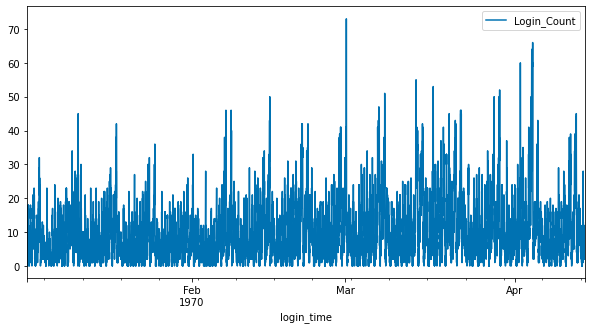

Login_Count    0
dtype: int64


In [38]:
_ = logins.plot(figsize=(10,5))
plt.show()
# Count the missing values of each time series
missing_values = logins.isna().sum()
print(missing_values)

Data looks a little chaotic due to high frequency. To better see patterns we need some modification. 

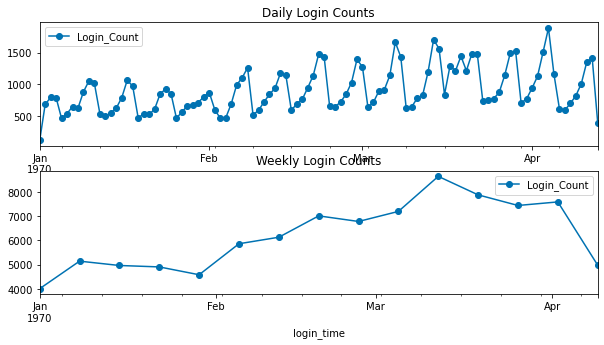

In [41]:
fig, ax = plt.subplots(2,1,figsize=(10,8))
logins.resample("D").sum().plot(figsize=(10,5), ax=ax[0], 
                                title="Daily Login Counts",
                               marker='o')
logins.resample("7d").sum().plot(figsize=(10,5), ax=ax[1], 
                                title="Weekly Login Counts",
                                marker='o')

plt.show()

Daily downgrading shows that there is a high weekly cycle in the data. The weekly login counts plot shows that the number of logins are increasing towards April then there is a sharp decrease at the secong week of April.

### Moving Average
Instead of weekly resampling we can also plot 7-day moving average from daily data for a smoother curve.

First of all, starting the week on Monday is helpful for rolling window calculations. Therefore, let's remove the entries until the first Monday.

In [138]:
logins.resample('D').sum().index[:7].dayofweek

Int64Index([3, 4, 5, 6, 0, 1, 2], dtype='int64', name='login_time')

Looks like the first Monday is the 5th day in the data.

In [139]:
logins_daily = logins.resample('D').sum()
logins_daily = logins_daily.iloc[4:-1]
logins_daily.index.dayofweek

Int64Index([0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0,
            1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1,
            2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2,
            3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3,
            4, 5, 6, 0, 1, 2, 3, 4, 5, 6],
           dtype='int64', name='login_time')

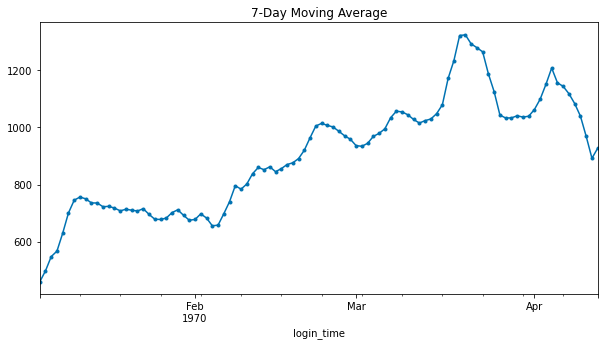

In [141]:
_ = logins_daily['Login_Count'].rolling(window="7D").\
    mean().plot(figsize=(10,5), marker=".", title="7-Day Moving Average")

As with the weekly logins counts plot, the 7-Day moving average plot suggest a rather strong trend in number of logins until the last week of the data

## Daily and Weekly Cycles

Now we will investigate the rush hours/days and quite hours/days

In [144]:
# Creating column for day of week
logins['hour'] = logins.index.hour
logins['day'] = logins.index.dayofweek
logins.head(4).T

login_time,1970-01-14 07:45:00,1970-01-12 23:45:00,1970-02-01 02:45:00,1970-03-26 17:00:00
Login_Count,2,3,17,4
hour,7,23,2,17
day,2,0,6,3


In [184]:
def cycle_plot(dt, time_group,top_pct, bottom_pct):
    """This function plots a mean cycle of the data for a given window
    dt: dataframe or a series
    time_group: hour, week column to group by
    top_pct: top percentile, float
    bottom_pct: bottom percentile, float"""
    
    fig, ax = plt.subplots(figsize=(10,5))
    daily_cycle = dt.groupby(time_group).mean()
    ax.plot(daily_cycle.index.values, daily_cycle["Login_Count"], 
            alpha=0.6, marker='.')
    daily_cycle = daily_cycle['Login_Count']
    # Plotting Extreme values
    # Busiest Hours
    critical_top = daily_cycle.quantile(top_pct)
    percentile_top = daily_cycle[daily_cycle > critical_top]
    ax.scatter(x=percentile_top.index.values, y=percentile_top, 
               label=f'Busiest {time_group}s', c="red", marker="*",s=70 )

    # Least Active Hours
    critical_bottom = daily_cycle.quantile(bottom_pct)
    percentile_bottom = daily_cycle[daily_cycle <= critical_bottom]
    ax.scatter(x=percentile_bottom.index.values, y=percentile_bottom, 
               label=f'Least Active {time_group}s', c="k", marker="*", s=50 )
    if time_group == 'day':
        ax.set_xticks(np.arange(7))
        ax.set_xticklabels(['Mon','Tue','Wd','Th', 'Fr', 'Sat', 'Sun'])
        ax.set_title("Mean Weekly Cycle")

    plt.legend()
    plt.plot()
    if time_group == 'hour':
        ax.xaxis.set_major_locator(MaxNLocator(8))
        ax.set_title("Mean Daily Cycle")
    plt.grid(True)
    plt.show()

    print(f"The most active {time_group}s\n {percentile_top}")
    print(f"The least active {time_group}s\n {percentile_bottom}")
    

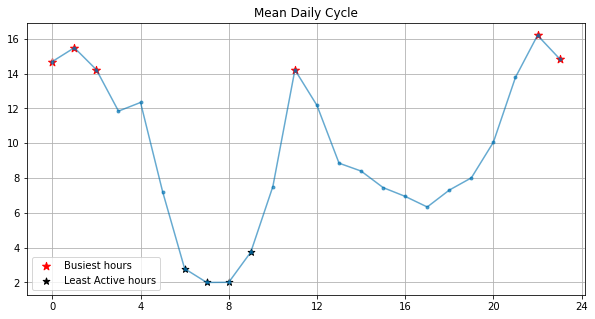

The most active hours
 hour
0     14.688725
1     15.482843
2     14.215686
11    14.213235
22    16.193627
23    14.848039
Name: Login_Count, dtype: float64
The least active hours
 hour
6    2.789216
7    1.997549
8    2.004902
9    3.742647
Name: Login_Count, dtype: float64


In [185]:
cycle_plot(logins, 'hour',0.75,0.15)

This plot shows that there is a strong daily cycle in login counts. The busiest hours are $\pm 2$ hours around midnight and around 11 am. The least active hours are the morning hours between $6$am to $9$am. 

Now let's see the average weekly cycle.

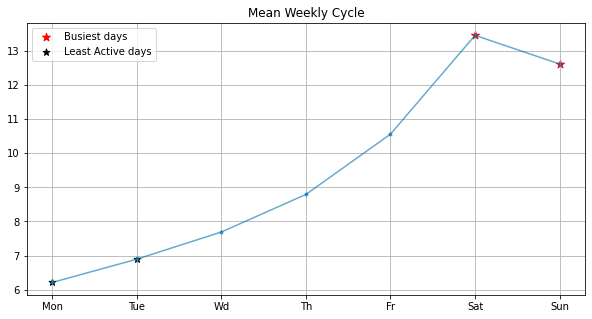

The most active days
 day
5    13.456250
6    12.615972
Name: Login_Count, dtype: float64
The least active days
 day
0    6.213380
1    6.895833
Name: Login_Count, dtype: float64


In [186]:
cycle_plot(logins, 'day',0.8,0.2)

The daily number of logins increases during the week as the weekand approaches, and peaks at Saturday. The busiest

## Stationarity of The Data

In [187]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

Since we know by now that strong daily and weekly cycles exist in the data we will only check autocorrelation plot of weekly logins

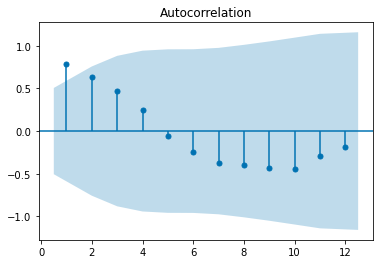

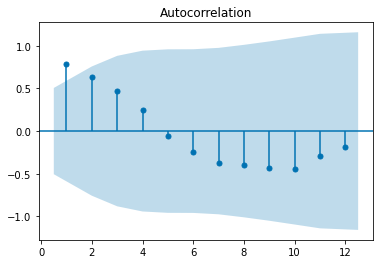

In [227]:
plot_acf(logins['Login_Count'].resample("7D").mean().values, alpha=0.05,zero=False)

Due to downgrading the data to weekly we lost most of the information. Therefore our confidence interval for $p=0.05$ is quitle thick. Still, the auto correlation plot of weekly logins suggest a lag-1 correlation.

We will now try to make the data stationary for a possible model building in the future

In [228]:
from statsmodels.tsa.stattools import kpss
y = logins['Login_Count']
kpss(y)

C:\Users\kurt_\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\kurt_\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1882: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


(2.989599815334273,
 0.01,
 38,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Since our p-value is less than 0.05 (more precisely less than 0.01 since the algorithm gives warning when p-value outsie the range (0.01, 0.1)), we should reject the Null hypothesis and deduce the non-stationarity of our data.

In [229]:
from statsmodels.tsa.stattools import adfuller as adf
for i in range(4):
    if i == 0:
        y_diff = y
    elif i > 0:
        y_diff = y.diff(periods=i).dropna()
    print(f'p-value of stationarity \
    for period={i} = {kpss(y_diff)[1]}')
    
    print(f'p-value of randomness \
    for period={i} = {adf(y_diff)[1]}')

C:\Users\kurt_\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1882: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


p-value of stationarity     for period=0 = 0.01
p-value of randomness     for period=0 = 2.7323966542226517e-18
p-value of stationarity     for period=1 = 0.1


C:\Users\kurt_\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\kurt_\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


p-value of randomness     for period=1 = 0.0
p-value of stationarity     for period=2 = 0.1


C:\Users\kurt_\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\kurt_\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


p-value of randomness     for period=2 = 0.0
p-value of stationarity     for period=3 = 0.1


C:\Users\kurt_\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\kurt_\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


p-value of randomness     for period=3 = 0.0


<span style="color:red">Since diff(1) p-value statistics is larger than 0.05 for adfuller test and smaller than 0.05 for kpss test one might take the first difference to make the data stationary for further modelling if needed to </span>

**Recall that adfuller test is used to test the randomness of the data, while kpss tests if the data stationary in general**

Let's take the first difference of the data and plot the daily logins after the first difference. Hopefully, this will take care of the weekly cycle as well as the daily cycle

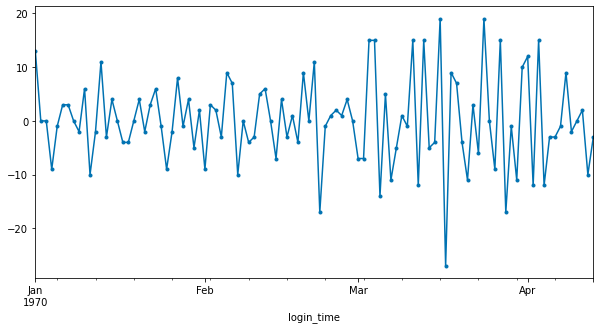

In [236]:
y_diff_daily = y.diff().resample('D').sum()
_ = y_diff_daily.plot(figsize=(10,5), marker='.')

There seems to be a pattern, but it is not as clear as before. Let's the statistics of the daily resampled data

In [243]:
kpss(y_diff_daily)[1]

C:\Users\kurt_\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\kurt_\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


0.1

In [239]:
adf(y_diff_daily)[1]

4.989515190280104e-08

kpss test suggest that daily time series logins after resampling is stationary and adf test suggest it is not a random walk

# Part 2

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
It is known that Ultimate Gotham is the most active at night and Ultimate Metropolis is the most active during the day. Also, the driver partners' activity which is the number of times the driver has crossed the bridge, is known. So, comparing before and after reimbursement data, we can find the result if experiment is successfull or not.

Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment

For this question, one-sample z-test is used to test the weather the mean of after-reimbursement data greater than or less than, or not equal to before-reimbursement. We will think two hypothesis here:

H0: It will represent the no effect, which means there will be no difference between number of times driver has crossed the bridge before and after reimbursement.

H1: It will represent the success, which means there will be sufficient difference between number of times driver has crossed the bridge before and after reimbursement.

b. what statistical test(s) you will conduct to verify the significance of the observation

One-tailed z test is applied to determine if there is a difference between two groups in a specific direction. The p-value, will show how likely the data could have occurred under the null hypothesis. If our p-value is under 0.05, means the reimbursement is successful. There is enough difference between before-after dataset. If p-value is above 0.05, it means the experiment is not successfull. There is not enough difference between two datasets.

c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

If the p-value is under 0.05, I would recommend the continue of reimbursement with the caveat that the test should be repeated after a limited time.

If the p-value is above the 0.05, I would recommend to reject the reimbursement and find another solution.

# Part 3

In [135]:
import seaborn as sns
# first we import the preprocessing package from the sklearn library
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, cv, plot_importance
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
import pickle

## A. EDA
* import data as a pandas DataFrame
* Explore the data types of columns
* Handling missing values
* Convert the data types to appropriate forms
* Exploratory Statistics

Reading json file as pandas DataFrame

In [5]:
df = pd.read_json("ultimate_data_challenge.json")
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


<div class="span5 alert alert-info">
We have two date columns but they are currently just strings. Let's make them datetime objects
    </div>

In [7]:
df["signup_date"] = pd.to_datetime(df["signup_date"])
df["last_trip_date"] =  pd.to_datetime(df["last_trip_date"])

<div class="span5 alert alert-info">
Now let's create the active users column. We have to find the users who were active during the last 30 days beore the data pulled
</div>

In [8]:
last_date = df["last_trip_date"].max()

# Calculate the number of days since the users' last trip  
num_days_last_trip = last_date - df['last_trip_date']

# 30 days as datetime object
_30days = pd.Timedelta("30D")

# If no_activity_days is shorter than 30 days the user is considered inactive
df['user_status'] = (num_days_last_trip < _30days).astype(int)

active_pct = round(df["user_status"].sum()/len(df), 3)
print(f"{active_pct*100}% of users are retained")

36.6% of users are retained


<div class="span5 alert alert-info">
Now let's see what each of these columns are made up off</div>

In [9]:
pd.DataFrame(df.nunique())

,0
city,3
trips_in_first_30_days,59
signup_date,31
avg_rating_of_driver,37
avg_surge,115
last_trip_date,182
phone,2
surge_pct,367
ultimate_black_user,2
weekday_pct,666


In [10]:
df[["city","phone"]].value_counts()

city            phone  
Winterfell      iPhone     15845
Astapor         iPhone     11169
King's Landing  iPhone      7568
Winterfell      Android     7280
Astapor         Android     5244
King's Landing  Android     2498
dtype: int64

In [11]:
df.aggregate([min,max,np.mean,np.median, np.std]).T

,min,max,mean,median,std
city,Astapor,Winterfell,NaN,NaN,NaN
trips_in_first_30_days,0,125,2.2782,1,3.79268
signup_date,2014-01-01 00:00:00,2014-01-31 00:00:00,2014-01-16 13:04:20.352011008,NaT,NaT
avg_rating_of_driver,1,5,4.60156,4.9,0.617338
avg_surge,1,8,1.07476,1,0.222336
last_trip_date,2014-01-01 00:00:00,2014-07-01 00:00:00,2014-04-19 08:02:04.992004352,NaT,NaT
surge_pct,0,100,8.84954,0,19.9588
ultimate_black_user,False,True,0.37708,0,0.48466
weekday_pct,0,100,60.9261,66.7,37.0815
avg_dist,0,160.96,5.79683,3.88,5.70736


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00
user_status,50000.0,0.366200,0.481770,0.0,0.00,0.00,1.00,1.00


<div class="span5 alert alert-info">
    <h3> Handling missing values</h3>
</div>

Looks like the following columns have some missing values

* avg_rating_of_driver
* phone
* avg_rating_by_driver

Now let's see the ratio of missing values. If not much, we could get rid of them. Otherwise, we can fill with an apropriate statistic of the column

In [13]:
nas=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df),columns = ['percent'])
pos = nas['percent'] > 0
nas[pos]*100

,percent
avg_rating_of_driver,16.244
phone,0.792
avg_rating_by_driver,0.402


In [14]:
# missing values
for column in ["avg_rating_of_driver", "phone", "avg_rating_by_driver"]:
    missing_ratio = df[column].isna().sum()/len(df) *100
    print(f"{missing_ratio}% of {column} is missing")

16.244% of avg_rating_of_driver is missing
0.792% of phone is missing
0.402% of avg_rating_by_driver is missing


<div class="span5 alert alert-info">
    The columns <code>phone</code> and <code>avg_rating_by_driver</code> have less than 1% missing values, thus we can just drop these rows. However, the <code>avg_rating_of_driver</code> column has significant amount of missing values, we should fill those values instead. let's see how it is distributed first.
</div>

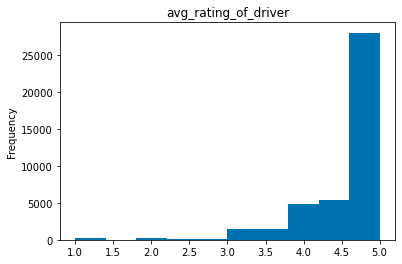

 median: 4.9
 mean: 4.6
 mode: 5.0


In [15]:
df['avg_rating_of_driver'].plot(kind='hist', title="avg_rating_of_driver")
plt.show()
_median = round(df['avg_rating_of_driver'].median(),2)
_mean = round(df['avg_rating_of_driver'].mean(),2)
_mode = round(df['avg_rating_of_driver'].mode()[0],2)
print(f" median: {_median}\n mean: {_mean}\n mode: {_mode}")

<div class="span5 alert alert-info"> Since the distribution of the data is not normal, strongly left skewed, filling the null values with median is more appropriate than filling with the mean
</div>

In [16]:
df['avg_rating_of_driver'].fillna(_median, inplace=True)
df['avg_rating_of_driver'].isna().sum()

0

In [17]:
df.dropna(subset=['phone','avg_rating_by_driver'], inplace = True)
nas=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df),columns = ['percent'])
pos = nas['percent'] > 0
nas[pos]

,percent


<div class="span5 alert alert-info">
Now that we have dealt with the missing values, let's look for duplicate rows, and drop them.
</div>

In [20]:
# Printing duplicated rows
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF.sort_values(by="signup_date")

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,user_status
29601,Winterfell,1,2014-01-01,4.9,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0,0
39601,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0,0
18057,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0,0
2608,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0,0
34641,Winterfell,1,2014-01-18,4.9,1.0,2014-01-19,iPhone,0.0,True,0.0,1.44,5.0,0
36627,Winterfell,1,2014-01-18,5.0,1.0,2014-01-19,Android,0.0,False,0.0,3.54,5.0,0
42025,Winterfell,1,2014-01-18,4.9,1.0,2014-01-19,Android,0.0,False,0.0,0.01,5.0,0
45416,Astapor,1,2014-01-20,5.0,1.0,2014-01-20,iPhone,0.0,False,100.0,3.06,5.0,0


In [21]:
# removing duplicates
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

<div class="span5 alert alert-info">Now the data is clean in terms of missing values, duplicated entries and datatypes </div>

**<font color='teal'> Histograms are an excellent way to review the range and density of values for each numeric features in our data set and build data profiles. Let's plot the histograms for all numeric features.</font>**

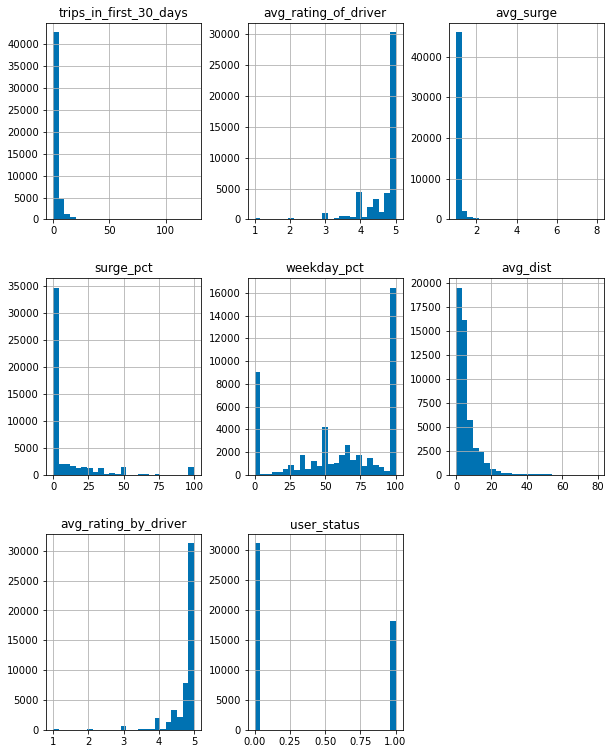

In [22]:
df.drop("ultimate_black_user", axis=1).hist(bins=25, figsize =(10,13))
plt.show()

<div class="span5 alert alert-info">
All the numeric variables are distributed in a way that they are either widely right skewed or left skewed except the weekday_pct, which is still not normally distributed at all.
    
There may be some correlation between the variables since their distributions look similar, such as between <code>avg_rating_of_driver</code> and <code>avg_rating_by_driver</code>
 Let's see the pairwise distribution of the numeric variables and then plot the correlation heat map.
</div>

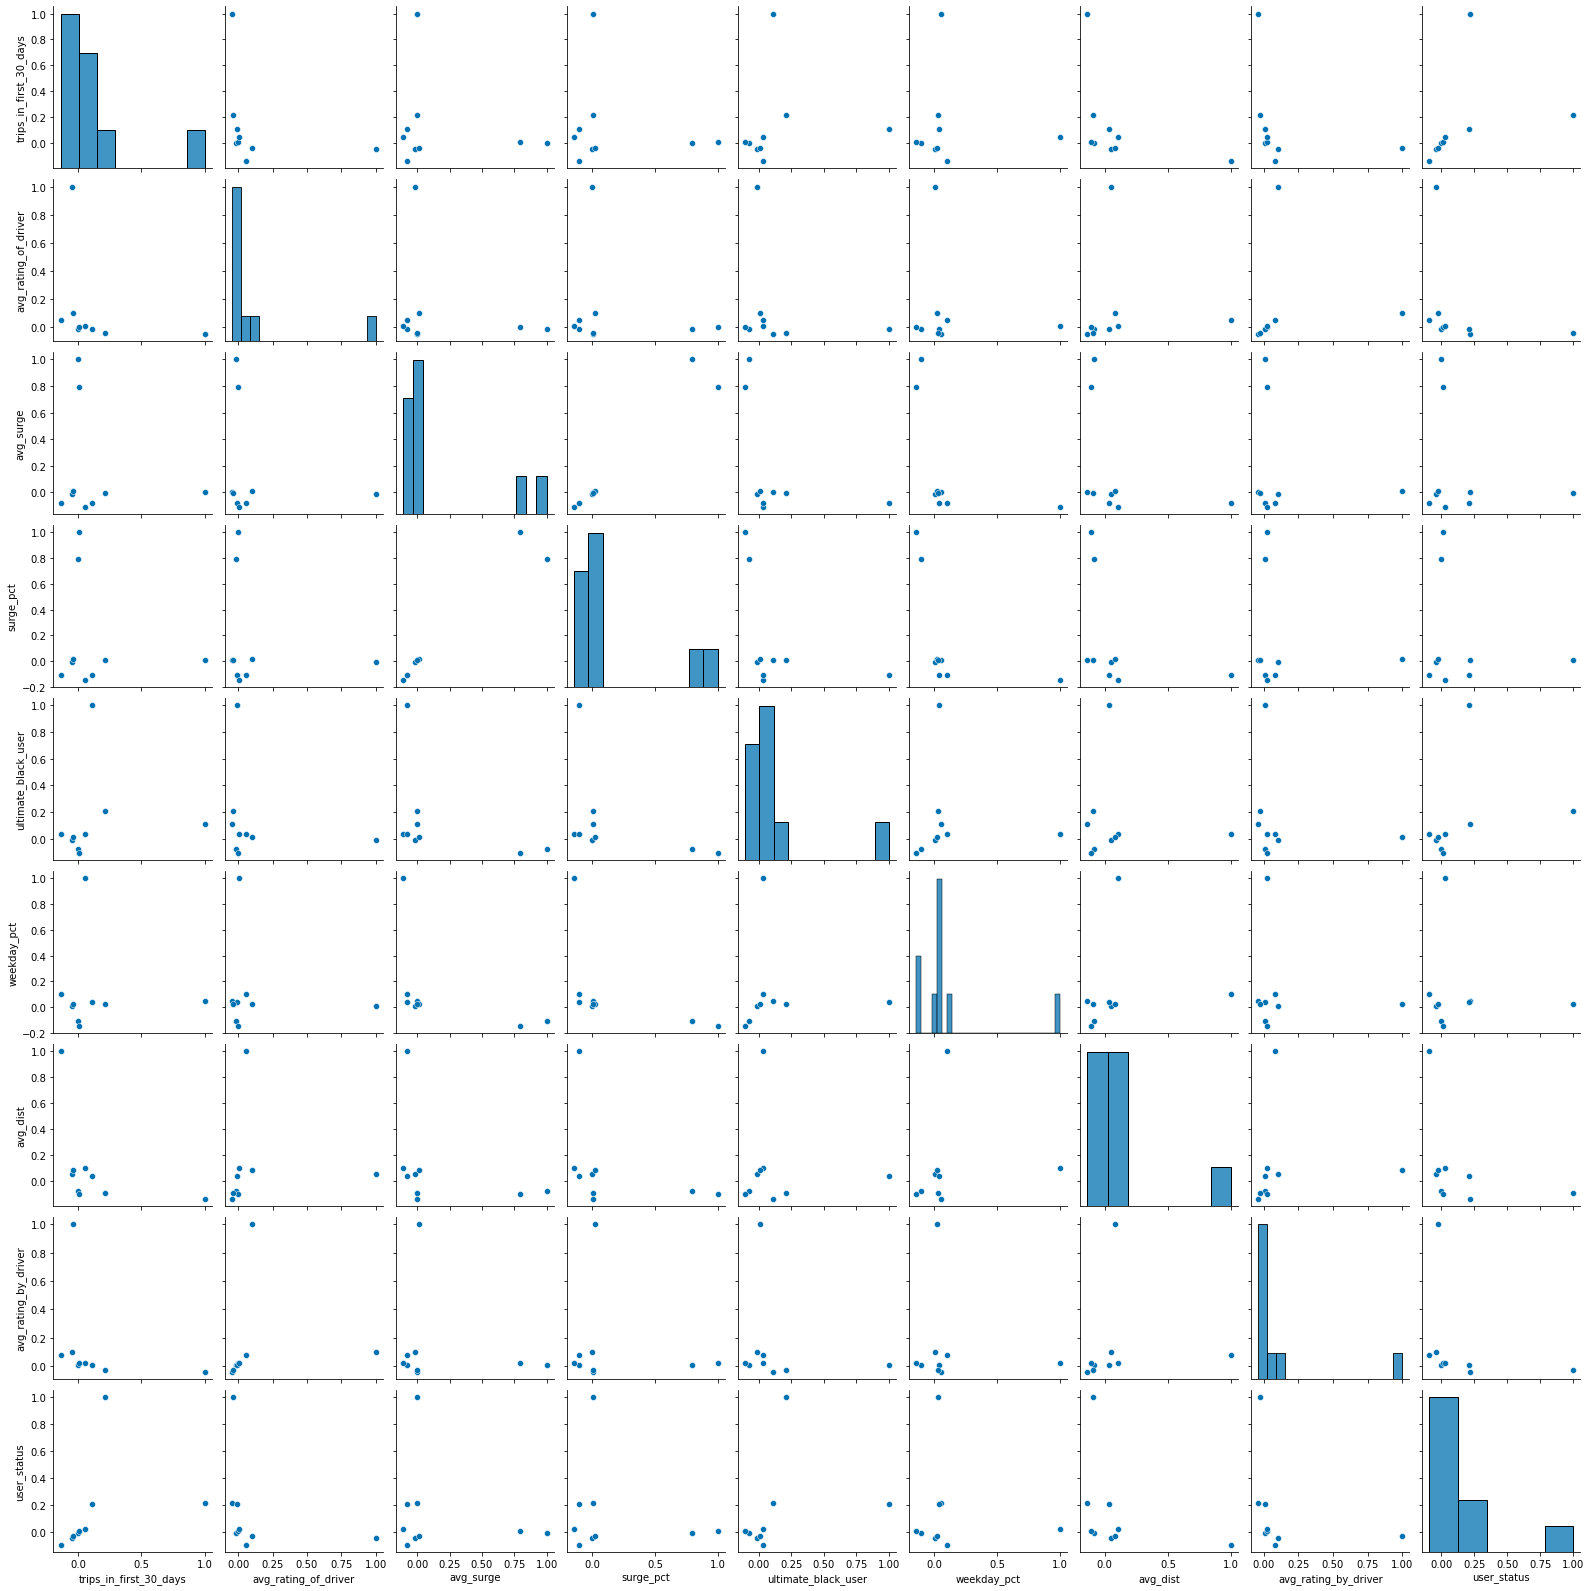

In [219]:
g = sns.pairplot(df.corr())

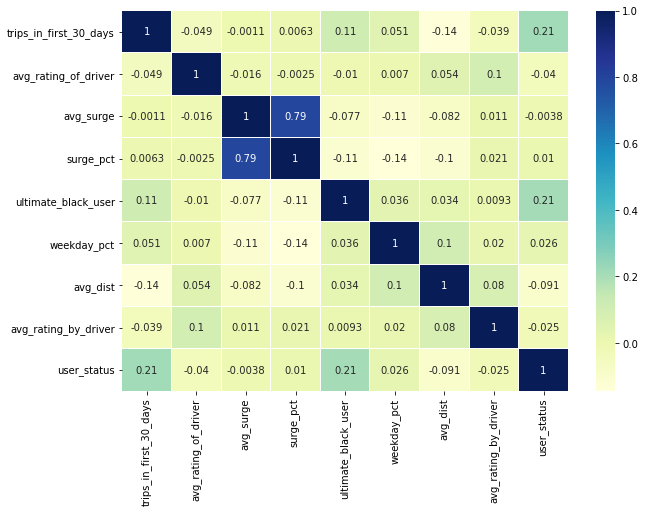

In [23]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.show()

<div class="span5 alert alert-info">
    There is only one pair that have a strong pairwise correlation: <code> avg_surge </code> vs. <code>srg_pct</code> correlation is <code>0.79</code>. This multicolinearity might cause an issue when building our models depending on the model type. For instance the regular regression models assumes that the features are not correlated to each other. Moreover, eventhough some models, such as Random Forest, can handle multicollinearity, it might still be helpful to exclude correlated features for the sake of simplicity especialy when it comes to making business decissions. I choose to drop surge percent because I believe that average surge brings more information to a model than surge percent.
</div>

In [24]:
# dataframe with no pairwise correlation
df.drop("surge_pct", axis=1, inplace=True)

In [224]:
df.select_dtypes('object').columns

Index(['city', 'phone'], dtype='object')

## Pre-Processing and Training Data Development

 * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set

In [63]:
# One-hot encoding categorical variables
df = pd.get_dummies(df)
# Coverting boolean variables to numeric
df.ultimate_black_user.replace({True:1, False:0}, inplace=True)
df.head(2)

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,user_status,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.1,2014-06-17,1,46.2,3.67,5.0,1,0,1,0,0,1
1,0,2014-01-29,5.0,1.0,2014-05-05,0,50.0,8.26,5.0,0,1,0,0,1,0


The signup_date might be a useful parameter in the model, so we want to convert it to numeric from datetime object

In [81]:
df['signup_date'] = df['signup_date'].dt.\
    strftime('%Y%m%d').astype(int) - 20140101 
# The last term is the first recorded signup date in this data

#### Standardize the magnitude of numeric features

## Modeling 
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

<div class="span5 alert alert-info">
    We will try a few classification methods. Because Random Forest allows categorical variables 
</div>

#### XGBoost Classifier

<div class="span5 alert alert-info">
Now splitting the data to train and test, but first we will drop the 'last_trip_date' column because it was used to calculate "user_status" feature.
</div>

In [82]:
#Prepare the dataset for modeling
X = df.drop(['user_status', 'last_trip_date', 'signup_date'], axis=1)
y = df["user_status"]
#Split dataset to train-test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

<div class="span5 alert alert-info">
We will first try the default parameters for the XGBoost classifier. Later, we will try to optimize the parameters and compare both results.
</div>

Let's first determine the optimum n_estimator. For this we will use a relativel high learning rate

In [90]:
params = {
    'learning_rate': [0.1],
    'n_estimators' : [100, 200, 500, 1000],
    'max_depth' : [6],
    'gamma': [0],
    'subsample':[0.8],
    "colsample_bytree": [0.8],
    'scale_pos_weight':[1]
    }

In [91]:
xgb_classifier = XGBClassifier(objective = 'binary:logistic', eval_metric='logloss',
                              use_label_encoder=False, seed=27)
# Training, Fitting with Gridsearch parameterization tunning
grid_search = GridSearchCV(param_grid= params, estimator = xgb_classifier, 
                           cv=5, scoring='accuracy')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                    

In [100]:
# The best n_estimator
print(grid_search.best_params_)
print(grid_search.best_score_)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 0.8}
0.7927873120143927


<div class="span5 alert alert-info">
We have found that the best value for n_estimator is 100. Now we will tune the other parameters
</div>

In [101]:
params = {
    'learning_rate': [0.1],
    'n_estimators' : [100],
    'max_depth' : [3,6,10],
    'gamma': [0],
    'subsample':[0.8],
    "colsample_bytree": [0.8],
    'scale_pos_weight':[1]
    }

In [102]:
xgb_classifier = XGBClassifier(objective = 'binary:logistic', eval_metric='logloss',
                              use_label_encoder=False)
# Training, Fitting with Gridsearch parameterization tunning
grid_search = GridSearchCV(param_grid= params, estimator = xgb_classifier, 
                           cv=5, scoring='accuracy')
grid_search.fit(X_train,y_train)
# The best n_estimator
print(grid_search.best_params_)
print(grid_search.best_score_)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 0.8}
0.7927873120143927


<div class="span5 alert alert-info">
The optimal vaue for max_depth is 6. Now le'ts find the optimal minimum_child_weight
</div>

In [105]:
params = {
    'learning_rate': [0.1],
    'n_estimators' : [100],
    'max_depth' : [6],
    'min_child_weight': [1, 3, 6, 8],
    'gamma': [0],
    'subsample':[0.8],
    "colsample_bytree": [0.8],
    'scale_pos_weight':[1]
    }
xgb_classifier = XGBClassifier(objective = 'binary:logistic', eval_metric='logloss',
                              use_label_encoder=False)
# Training, Fitting with Gridsearch parameterization tunning
grid_search = GridSearchCV(param_grid= params, estimator = xgb_classifier, 
                           cv=5, scoring='accuracy')
grid_search.fit(X_train,y_train)
# The best n_estimator
print(grid_search.best_params_)
print(grid_search.best_score_)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 0.8}
0.7929897328002135


<div class="span5 alert alert-info">
The optimal vaue for min_child_weight is 6. Since these are important parameters we will now fine tune these parameters
</div>

In [106]:
params = {
    'learning_rate': [0.1],
    'n_estimators' : [100],
    'max_depth' : [5, 6, 7],
    'min_child_weight': [ 5, 6, 7],
    'gamma': [0],
    'subsample':[0.8],
    "colsample_bytree": [0.8],
    'scale_pos_weight':[1]
    }
xgb_classifier = XGBClassifier(objective = 'binary:logistic', eval_metric='logloss',
                              use_label_encoder=False)
# Training, Fitting with Gridsearch parameterization tunning
grid_search = GridSearchCV(param_grid= params, estimator = xgb_classifier, 
                           cv=5, scoring='accuracy')
grid_search.fit(X_train,y_train)
# The best n_estimator
print(grid_search.best_params_)
print(grid_search.best_score_)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 0.8}
0.793394653829635


<div class="span5 alert alert-info">
Now we have updated the optimal value for min_child_weight to 7
</div>

#### Tune Gamma

In [108]:

params = {
    'learning_rate': [0.1],
    'n_estimators' : [100],
    'max_depth' : [6],
    'min_child_weight': [7],
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[0.8],
    "colsample_bytree": [0.8],
    'scale_pos_weight':[1]
    }
xgb_classifier = XGBClassifier(objective = 'binary:logistic', eval_metric='logloss',
                              use_label_encoder=False)
# Training, Fitting with Gridsearch parameterization tunning
grid_search = GridSearchCV(param_grid= params, estimator = xgb_classifier, 
                           cv=5, scoring='accuracy')
grid_search.fit(X_train,y_train)
# The best n_estimator
print(grid_search.best_params_)
print(grid_search.best_score_)

{'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 0.8}
0.793394653829635


<div class="span5 alert alert-info">
The optimal gamma is 0
</div>

#### Tune subsample and colsample_bytree

In [110]:

params = {
    'learning_rate': [0.1],
    'n_estimators' : [100],
    'max_depth' : [6],
    'min_child_weight': [7],
    'gamma':[0],
    'subsample':[0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    'scale_pos_weight':[1]
    }
xgb_classifier = XGBClassifier(objective = 'binary:logistic', eval_metric='logloss',
                              use_label_encoder=False)
# Training, Fitting with Gridsearch parameterization tunning
grid_search = GridSearchCV(param_grid= params, estimator = xgb_classifier, 
                           cv=5, scoring='accuracy')
grid_search.fit(X_train,y_train)
# The best n_estimator
print(grid_search.best_params_)
print(grid_search.best_score_)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 0.9}
0.793626034885311


<div class="span5 alert alert-info">
optimal values for subsample is 0.9 , for colsample_bytree is 0.8. Notice that the best score gain is exponentially decreasing. We will now explore the final parameter: learning rate
</div>

#### Tuning Regularization Parameters
reg_alpha paremeter tunning can help to reduce overfitting. Let's try the optimal value for this as best as we can

In [111]:

params = {
    'learning_rate': [0.1],
    'n_estimators' : [100],
    'max_depth' : [6],
    'min_child_weight': [7],
    'gamma':[0],
    'subsample':[0.9],
    "colsample_bytree": [0.8],
    'scale_pos_weight':[1],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
    }
xgb_classifier = XGBClassifier(objective = 'binary:logistic', eval_metric='logloss',
                              use_label_encoder=False)
# Training, Fitting with Gridsearch parameterization tunning
grid_search = GridSearchCV(param_grid= params, estimator = xgb_classifier, 
                           cv=5, scoring='accuracy')
grid_search.fit(X_train,y_train)
# The best n_estimator
print(grid_search.best_params_)
print(grid_search.best_score_)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'reg_alpha': 1, 'scale_pos_weight': 1, 'subsample': 0.9}
0.7937127400513632


<div class="span5 alert alert-info">
The optimal value for reg_alpha is 1. Now that we have found the best values for the parameters among the ranges we tested, we an now tune the final parameter, the <b>learning_rate</b>. As we lower the learning rate, we will increase the number of trees.
</div>

In [137]:

params = {
    'learning_rate': [0.01],
    'n_estimators' : [500, 1000, 2500, 3000],
    'max_depth' : [6],
    'min_child_weight': [7],
    'gamma':[0],
    'subsample':[0.9],
    "colsample_bytree": [0.8],
    'scale_pos_weight':[1],
    'reg_alpha':[1]
    }
xgb_classifier = XGBClassifier(objective = 'binary:logistic', eval_metric='logloss',
                              use_label_encoder=False)
# Training, Fitting with Gridsearch parameterization tunning
grid_search = GridSearchCV(param_grid= params, estimator = xgb_classifier, 
                           cv=5, scoring='accuracy')
grid_search.fit(X_train,y_train)
# The best n_estimator
print(grid_search.best_params_)
print(grid_search.best_score_)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 2500, 'reg_alpha': 1, 'scale_pos_weight': 1, 'subsample': 0.9}
0.7951298779235758


<div class="span5 alert alert-info">
Optimal n_estimators is 2500. We are now ready to use our final model to fit and test using the test data
</div>

In [139]:
xgb_classifier = XGBClassifier(objective = 'binary:logistic', eval_metric='logloss',
                              use_label_encoder=False,learning_rate= 0.01,
                              n_estimators=2500, max_depth=6, gamma=0, subsample=0.9,
                              min_child_weight=7, colsample_bytree=0.8, scale_pos_weight=1,
                              reg_alpha=1)
xgb_classifier.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=6, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=2500, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=1, reg_lambda=1,
              scale_pos_weight=1, subsample=0.9, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [141]:
# predict labels from train data
y_pred = grid_search.predict(X_train)
# score model
score = accuracy_score(y_train, y_pred)
# print accuracy
print(f"The accuracy of the model is {round(score,3)} based on training set.")

The accuracy of the model is 0.829 based on training set.


We have improved the model score as best as we can with the parameter tunning. Now we will test the model with the test data

In [142]:
pickle.dump(xgb_classifier, open('xgb_classifier.pkl', 'wb'))

#### Testing the final model

In [145]:
# predict the labels
y_pred = xgb_classifier.predict(X_test)
# score model
score = accuracy_score(y_test, y_pred)
# print accuracy
print(f"The accuracy of the model based on test set. is {round(score,3)}")

The accuracy of the model based on test set. is 0.797


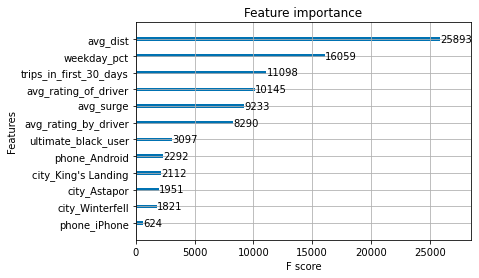

In [148]:
plot_importance(xgb_classifier)
plt.show()